In [23]:
pip install pandas numpy matplotlib statsmodels prophet xgboost

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


In [36]:
# Read CSV correctly (comma-separated)
data = pd.read_csv("household_power_consumption.csv", sep=",", na_values=["?"])

# Combine Date and Time into a single datetime column
data["datetime"] = pd.to_datetime(data["Date"] + " " + data["Time"], dayfirst=True, errors="coerce")

# Keep only datetime + Global_active_power
data = data[["datetime", "Global_active_power"]].dropna()

# Set datetime as index
data = data.set_index("datetime")

print(data.head())

                     Global_active_power
datetime                                
2006-12-16 17:24:00                4.216
2006-12-16 17:25:00                5.360
2006-12-16 17:26:00                5.374
2006-12-16 17:27:00                5.388
2006-12-16 17:28:00                3.666


In [39]:
# Resample to hourly data (mean of Global_active_power)
data_hourly = data['Global_active_power'].resample('H').mean().fillna(method='ffill')
data_hourly = pd.DataFrame(data_hourly, columns=['Global_active_power'])

In [40]:
# Split data into train and test (last 7 days for testing)
train = data_hourly[:-168]  # 7 days * 24 hours
test = data_hourly[-168:]

In [41]:
# 2. Feature Engineering
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['month'] = df.index.month
    df['lag_1'] = df['Global_active_power'].shift(1)  # 1-hour lag
    df['lag_24'] = df['Global_active_power'].shift(24)  # 24-hour lag
    return df

In [42]:
# Apply feature engineering
data_hourly = create_features(data_hourly)
train = create_features(train)
test = create_features(test)

In [43]:
# Drop NaN values created by lagging
train = train.dropna()
test = test.dropna()

In [44]:
# 3. Model Training and Evaluation

# 3.1 ARIMA Model
arima_model = ARIMA(train['Global_active_power'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=len(test))

In [45]:
# Evaluate ARIMA
arima_rmse = np.sqrt(mean_squared_error(test['Global_active_power'], arima_pred))
arima_mae = mean_absolute_error(test['Global_active_power'], arima_pred)
print(f'ARIMA RMSE: {arima_rmse:.4f}, MAE: {arima_mae:.4f}')

ARIMA RMSE: 1.0417, MAE: 0.8878


In [47]:
# 3.2 Prophet Model
prophet_df = train.reset_index()[['datetime', 'Global_active_power']].rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
prophet_test_df = test.reset_index()[['datetime', 'Global_active_power']].rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=len(test), freq='H')
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast.tail(len(test))['yhat'].values

prophet_rmse = np.sqrt(mean_squared_error(test['Global_active_power'], prophet_pred))
prophet_mae = mean_absolute_error(test['Global_active_power'], prophet_pred)
print(f'Prophet RMSE: {prophet_rmse:.4f}, MAE: {prophet_mae:.4f}')

17:32:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 0.7307, MAE: 0.5593


In [48]:
# 3.3 XGBoost Model
features = ['hour', 'dayofweek', 'is_weekend', 'month', 'lag_1', 'lag_24']
X_train = train[features]
y_train = train['Global_active_power']
X_test = test[features]
y_test = test['Global_active_power']

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
print(f'XGBoost RMSE: {xgb_rmse:.4f}, MAE: {xgb_mae:.4f}')

XGBoost RMSE: 0.5835, MAE: 0.4134


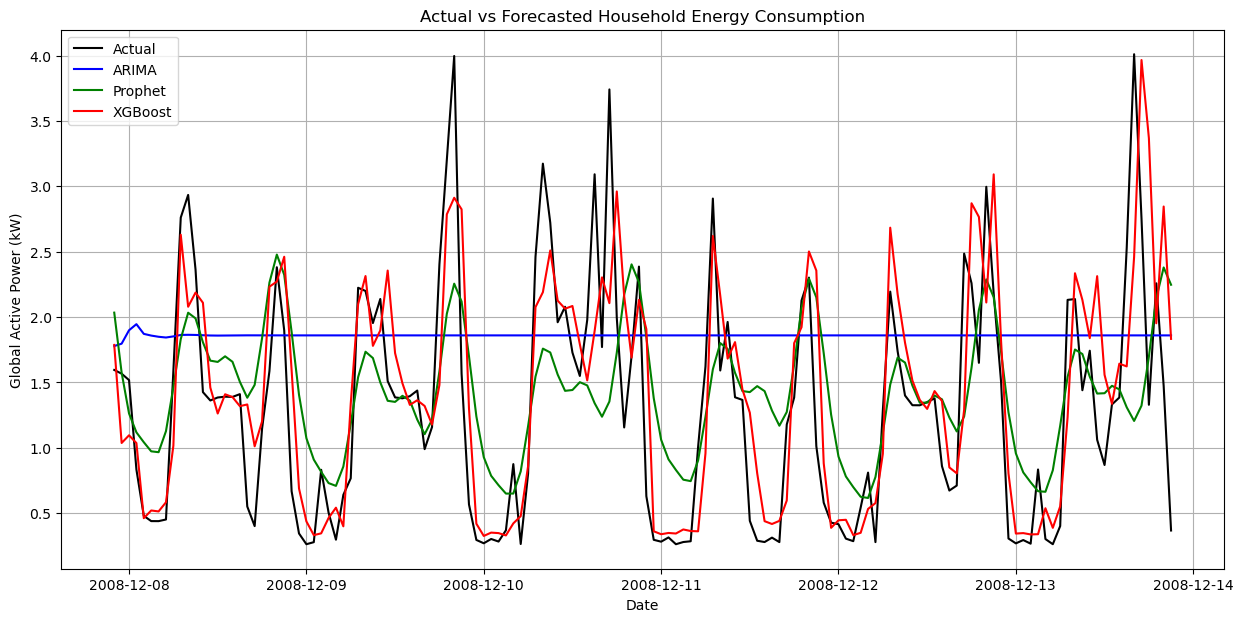

In [49]:
# 4. Plot Actual vs Forecasted Values
plt.figure(figsize=(15, 7))
plt.plot(test.index, test['Global_active_power'], label='Actual', color='black')
plt.plot(test.index, arima_pred, label='ARIMA', color='blue')
plt.plot(test.index, prophet_pred, label='Prophet', color='green')
plt.plot(test.index, xgb_pred, label='XGBoost', color='red')
plt.title('Actual vs Forecasted Household Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# 5. Summarize Model Performance
performance = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'RMSE': [arima_rmse, prophet_rmse, xgb_rmse],
    'MAE': [arima_mae, prophet_mae, xgb_mae]
})
print("\nModel Performance Summary:")
print(performance)


Model Performance Summary:
     Model      RMSE       MAE
0    ARIMA  1.041711  0.887821
1  Prophet  0.730667  0.559254
2  XGBoost  0.583490  0.413429
